In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/val.csv")
test_df = pd.read_csv("../data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31255
val size 3473
test size 8682


In [4]:
train_df.sample(10)

,text,label
28997,If it’s fan made they deserve an award. Or mon...,0
14828,That does make sense. Thanks.,0
23668,That makes me feel even pettier. Thanks!,0
18056,"I’m glad things are coming to light, I pray ju...",0
11131,"nice IASIP refernece! ""made a pretty penny in ...",0
14457,"I am real excited for this, I just hope they d...",0
7476,It's very hard to be an alcoholic drinking onl...,0
30233,It's weird that actual socialists will say tha...,1
13263,YES PLEASE... I thought they did a while back ...,1
558,I would like to thank this game for being over...,0


<AxesSubplot:>

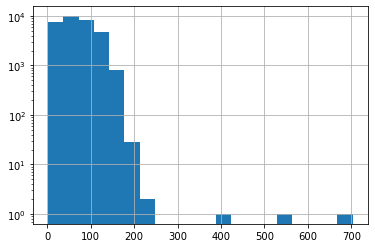

In [5]:
length_dist = train_df["text"].apply(len)
length_dist.hist(log=True, bins=20)

In [6]:
train_df.groupby("label").count()

,text
label,
0,24718
1,6537


In [7]:
train_neg = train_df[train_df["label"] == 0]
train_pos = train_df[train_df["label"] == 1]

train_neg

,text,label
0,takes no time to copy/paste a press release,0
2,Jazz fan here. I completely feel. Lindsay Mann...,0
3,ah i was also confused but i think they mean f...,0
4,Thank you so much. ♥️ that means a lot.,0
5,And I’ll be there!!!,0
...,...,...
31250,thank you so much! :),0
31251,That works too. To each their own.,0
31252,"Friendly fire dude, I wanted the other criminal",0
31253,"Yes, exactly. Fix a date and if he still procr...",0


In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

en_stopwords = stopwords.words('english')
en_stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/students/acct3001_02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/students/acct3001_02/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
en_stopwords = set(en_stopwords)

In [10]:
def count_unigram(texts):
    vocab = {}

    for x in texts:
        words = x.lower().split()
        for w in words:
            if w not in en_stopwords:
                vocab[w] = vocab.get(w,0) + 1

    vocab = pd.DataFrame.from_dict(vocab, orient="index", columns=["count"])
    vocab.sort_values("count", ascending=False, inplace=True)
    
    return vocab

pos_unigram = count_unigram(train_pos["text"])
neg_unigram = count_unigram(train_neg["text"])

In [11]:
pos_unigram.T

,like,i'm,people,get,sorry,even,really,one,think,would,...,times!,gift,idiots....sheep,thinkers,changes,chemist.,remind,goddamit.,redpiller,dummy
count,509,348,321,285,254,233,231,228,213,212,...,1,1,1,1,1,1,1,1,1,1


In [12]:
neg_unigram.T

,like,love,would,i'm,get,good,one,think,people,really,...,janitors,icu.,minnesota?,reciprocal,rinds?,sullivan.,apparantly,boomhauer(?)(boom-how-er),stealthy,"least,"
count,1784,1258,1008,1007,961,961,907,812,779,770,...,1,1,1,1,1,1,1,1,1,1


Data is clean and does not need any cleaning. 



In [13]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [14]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=512, truncation=True, padding=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=512, truncation=True, padding=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=512, truncation=True, padding=True)

In [15]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

In [17]:
train_dataset[0]

{'input_ids': tensor([  101,  3138,  2053,  2051,  2000,  6100,  1013, 19351,  1037,  2811,
          2713,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 

In [ ]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=512,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss


In [29]:
model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-93")
model = model.cuda()
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [25]:
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [33]:
results = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.cuda() for k,v in batch.items()}
        output = model(**batch)
        results.append(output["logits"].cpu())


In [34]:
results = torch.cat(results)
results = torch.argmax(results, dim=1)
results

tensor([1, 0, 0,  ..., 0, 0, 0])

In [35]:
submission = test_df.copy()
submission["label"] = results.numpy()
submission

,text,label
0,I was already over the edge with Cassie Zamora...,1
1,I think you're right. She has oodles of cash a...,0
2,Haha I love this. I used to give mine phone bo...,0
3,Probably out of desperation as they going no a...,1
4,Sorry !! You’re real good at that!!,1
...,...,...
8677,Yeah no...I would find it very demeaning,1
8678,This is how mafia works,0
8679,Ah thanks 👍🏻,0
8680,I ask them straight why they don't respect my ...,0


In [36]:
submission.to_csv("submission.csv", index=False)